In [1]:
#htsf\Scripts\activate    

# Import libraries
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from plotnine import ggplot, aes, geom_line
import statsmodels.api as sm
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from dateutil.relativedelta import relativedelta
import itertools
import hts

%matplotlib inline


# Read 
df = pd.read_csv('../data/dataset.csv')
df.head()

,Data Type,Month,Client,Responsible,Est Hrs
0,Actual,1/1/2021,Client 69,Team Member 20,41.0
1,Actual,1/1/2021,Client 27,Team Member 36,35.0
2,Actual,1/1/2021,Client 47,Team Member 21,24.0
3,Actual,1/1/2021,Client 38,Team Member 24,23.0
4,Actual,1/1/2021,Client 48,Team Member 27,20.0


In [2]:
# Update Data Types
df['Data Type'] = df['Data Type'].astype('category')
df['Month'] = pd.to_datetime(df['Month'])
df['Client'] = df['Client'].astype('category')
df['Responsible'] = df['Responsible'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data Type    1283 non-null   category      
 1   Month        1283 non-null   datetime64[ns]
 2   Client       1283 non-null   category      
 3   Responsible  1283 non-null   category      
 4   Est Hrs      1283 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(1)
memory usage: 28.0 KB


In [3]:
# Exploratory Analysis

def get_column_description(data):
    for col in data.columns:
        if data[col].dtype == 'category':
            print(f'{col} unique values: {len(data[col].unique())}\n')
        elif data[col].dtype == 'datetime64[ns]':
            print(f'Min Date: {data[col].min()}')
            print(f'Max Date: {data[col].max()}\n')
        else:
            print(f'{col}:\n{df[col].describe()}\n')

get_column_description(df)

Data Type unique values: 1

Min Date: 2021-01-01 00:00:00
Max Date: 2022-01-01 00:00:00

Client unique values: 70

Responsible unique values: 39

Est Hrs:
count    1283.000000
mean       11.120800
std        10.677368
min         0.400000
25%         4.000000
50%         8.000000
75%        14.500000
max        95.000000
Name: Est Hrs, dtype: float64



In [4]:
df.groupby(['Responsible', 'Client']).count().rename(columns={'Data Type': 'Count'}).sort_values(by='Count', ascending=False).Count

Responsible     Client   
Team Member 12  Client 18    13
Team Member 22  Client 69    13
Team Member 16  Client 19    13
                Client 54    13
Team Member 23  Client 18    13
                             ..
Team Member 21  Client 9      0
Team Member 22  Client 1      0
                Client 13     0
                Client 15     0
Team Member 9   Client 9      0
Name: Count, Length: 2730, dtype: int64

,Data Type,Month,Client,Responsible,Est Hrs
Month,,,,,
2021-01-01,Actual,2021-01-01,Client 18,Team Member 12,6.00
2021-02-01,Actual,2021-02-01,Client 18,Team Member 12,7.50
2021-03-01,Actual,2021-03-01,Client 18,Team Member 12,2.50
2021-04-01,Actual,2021-04-01,Client 18,Team Member 12,2.50
2021-05-01,Actual,2021-05-01,Client 18,Team Member 12,1.25
2021-06-01,Actual,2021-06-01,Client 18,Team Member 12,3.50
2021-07-01,Actual,2021-07-01,Client 18,Team Member 12,2.00
2021-08-01,Actual,2021-08-01,Client 18,Team Member 12,6.50
2021-09-01,Actual,2021-09-01,Client 18,Team Member 12,8.50


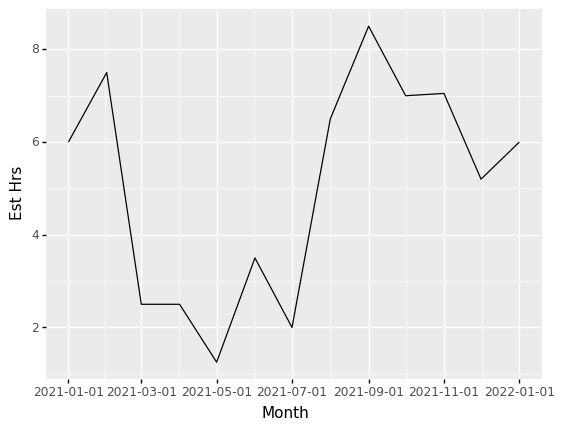

<ggplot: (91528171611)>

In [5]:
# Example of Team member with all 13 months with one client
example = df.loc[(df.Responsible == 'Team Member 12') & (df.Client == 'Client 18')].sort_values(by='Month')
example.index = pd.DatetimeIndex(example.Month, freq=pd.DatetimeIndex(example.Month).inferred_freq)

display(example)

(
    ggplot(example)
    + aes(x='Month', y='Est Hrs')
    + geom_line()
)

In [6]:
# Because there aren't a complete 13-month range for each team member, do some pre-processing filling in empty months with zero

def fill_empty_dates(data):
    unique_pairs = data[['Responsible', 'Client']].drop_duplicates().sort_values(by=['Responsible', 'Client'])
    dates = pd.concat([pd.DataFrame({'Month':pd.date_range(datetime(2021, 1, 1), periods=13, freq='1M') - pd.offsets.MonthBegin(1)})]*len(unique_pairs), ignore_index=True)
    resp_cli = pd.concat([unique_pairs]*13, ignore_index=True).sort_values(by=['Responsible', 'Client'])
    out = pd.DataFrame({
        'Month':dates.Month,
        'Responsible':resp_cli.Responsible,
        'Client':resp_cli.Client
    }).sort_values(by=['Responsible', 'Client', 'Month']).reset_index(drop=True)

    out = pd.merge(out, data.drop(columns='Data Type', axis=1), how='left', on=['Month', 'Responsible', 'Client'])
    out.loc[out['Est Hrs'].isna(), 'Est Hrs'] = 0
    return out

df = fill_empty_dates(df)


c:\Users\benton.tripp\Box\Benton Tripp\Personal\Projects\hyperarchal-ts\htsf\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


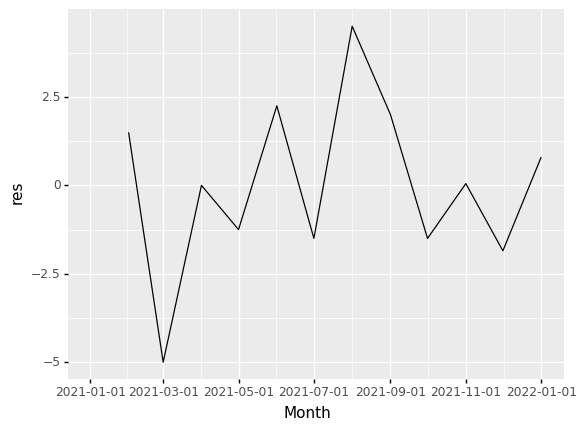

<ggplot: (91528171767)>

In [7]:
# Statistical tests/EDA - whether data is stationary, granger-causality, distributions, visualizations

# One of the challenges with this dataset is there is only one "cycle" of data (only one complete year). 
# You typically need at least two complete cycles of data in order to infer any seasonality. However,
# we can still make an effort to ensure the data is stationary (not a trend in the data) prior to 
# using any forecast methods where stationary data is a constraint.


# Make data stationary by using the `diff()` function
example['res'] = example['Est Hrs'].diff()

(
    ggplot(example)
    + aes(x='Month', y='res')
    + geom_line()
)

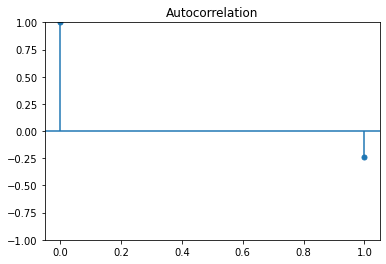

In [8]:
ac_plt = tsaplots.plot_acf(example.res.dropna(), lags = 1)

                               SARIMAX Results                                
Dep. Variable:                    res   No. Observations:                   13
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -38.251
Date:                Thu, 26 May 2022   AIC                             78.502
Time:                        10:27:28   BIC                             78.986
Sample:                    01-01-2021   HQIC                            78.322
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        14.7871     10.011      1.477      0.140      -4.834      34.408
Ljung-Box (L1) (Q):                   5.62   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.02   Pr

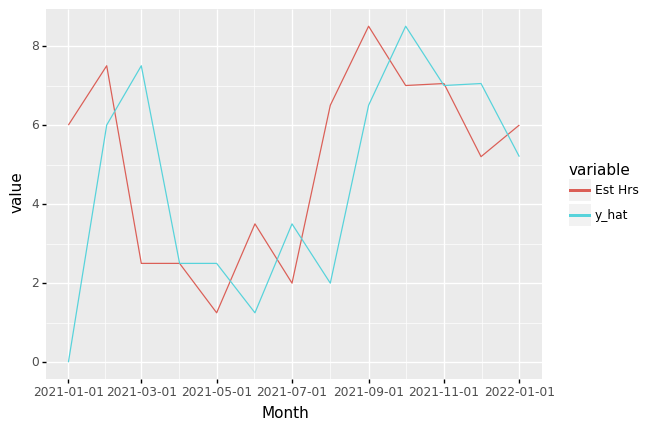

<ggplot: (91529371037)>

In [9]:
# Naive Baseline of Example - a quick example of the "Score to beat"

mod = ARIMA(example.res, order=(0,1,0))
res = mod.fit()

print(res.summary())

example['y_hat'] = res.predict()
example.loc[datetime(2021,2,1), 'y_hat'] = example['Est Hrs'].iloc[0]
example['y_hat'] = example['y_hat'].cumsum()
(
    ggplot(example[['Month', 'Est Hrs', 'y_hat']].melt(id_vars='Month'))
    + aes(x='Month', y='value', color='variable')
    + geom_line()
)

                               SARIMAX Results                                
Dep. Variable:                    res   No. Observations:                   13
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -34.680
Date:                Thu, 26 May 2022   AIC                             73.360
Time:                        10:27:28   BIC                             74.329
Sample:                    01-01-2021   HQIC                            73.000
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7564      0.221     -3.429      0.001      -1.189      -0.324
sigma2         7.1514      3.584      1.995      0.046       0.127      14.176
Ljung-Box (L1) (Q):                   0.00   Jarque-

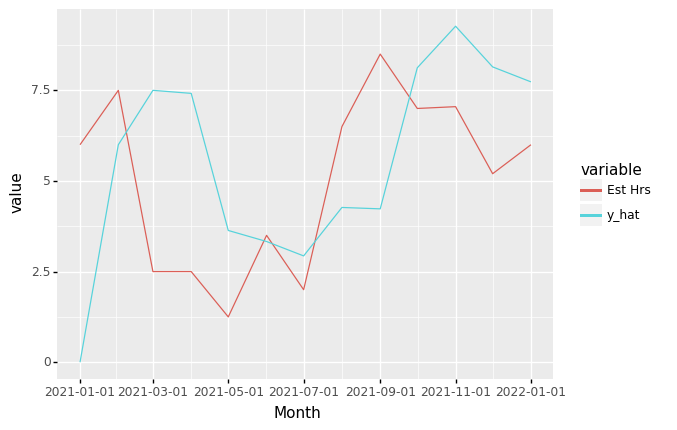

<ggplot: (91529364441)>

In [10]:
mod = ARIMA(example.res, order=(1,1,0))
res = mod.fit()

print(res.summary())

example['y_hat'] = res.predict()
example.loc[datetime(2021,2,1), 'y_hat'] = example['Est Hrs'].iloc[0]
example['y_hat'] = example['y_hat'].cumsum()
(
    ggplot(example[['Month', 'Est Hrs', 'y_hat']].melt(id_vars='Month'))
    + aes(x='Month', y='value', color='variable')
    + geom_line()
)

In [11]:
# Make all data stationary
df['res'] = df.groupby(['Responsible', 'Client'])['Est Hrs'].diff()

# Naive Baseline (Random Walk)

def get_pred(data, pred, col):
    data = data.reset_index(drop=True)
    pred[1] = data.iloc[0]['Est Hrs']
    data[col] = pred.cumsum().values
    return data

def naive_baseline(data):
    data.index = pd.DatetimeIndex(data.Month, freq=pd.DatetimeIndex(data.Month).inferred_freq)
    mod = ARIMA(data.res, order=(0,1,0), freq='MS')
    data = get_pred(data, mod.fit().predict(), 'baseline')
    return data

#nb = df.groupby(['Responsible', 'Client'], as_index=False, observed=True).apply(func=naive_baseline).reset_index(drop=True)

In [94]:
# Heirarchal - Each client is a part of the whole for each Team Member; Each Team member is part of the overall Team

def get_hierarchy(data, lvl1, lvl2):
    new_ = f'{lvl1}_{lvl2}'
    data[new_] = data.apply(lambda x: f'{x[lvl1]}_{x[lvl2]}', axis=1)
    l1s = data[lvl1].unique()
    l2s = data[new_].unique()
    total = {'total': list(l1s)}
    btm = {k: [v for v in l2s if k == v.split('_')[0]] for k in l1s}
    hier = {**total, **btm}
    btm = list(itertools.chain.from_iterable(btm.values()))
    labs = ['total'] + data[lvl2].unique().tolist() + l1s.tolist() + btm
    return hier, new_, btm, labs

def get_hierarchal(data, lvl1, lvl2, date_col='Month', val='Est Hrs'):
    hier, new_, btm, labs = get_hierarchy(data, lvl1, lvl2)
    hd = data.pivot(index=date_col, columns=new_, values=val)\
        .join(
            data.groupby([date_col, lvl1], as_index=False, observed=True)\
                .agg({val : lambda x: data.loc[x.index][val].sum()})\
                    .pivot(index=date_col, columns=lvl1, values=val)
            )\
                .join(
                    data.groupby(date_col, observed=True)\
                        .agg({val : lambda x: data.loc[x.index][val].sum()})\
                            .rename(columns={val:'total'})
                    )
    hd.index = pd.DatetimeIndex(hd.index, freq=hd.index.inferred_freq)
    return hier, hd, btm, labs

def map_hierarchies(col):
    col.loc[col.name.split('_')] = 1
    return col

hierarchy, hierarchy_df, bottom, labels = get_hierarchal(df, 'Responsible', 'Client')   

id_mat = np.vstack(
    (
        np.ones(len(bottom)), 
        pd.DataFrame(index=labels[1:len(labels)-len(bottom)], columns=bottom, data=0).apply(lambda x: map_hierarchies(x)).values, 
        np.identity(len(bottom))
    )
)

In [13]:
# Using the scikit-hts package

# hw = hts.HTSRegressor(model='holt_winters', revision_method='OLS', n_jobs=1)
# hw = hw.fit(hierarchy_df, nodes=hierarchy)
# hw_pred = hw.predict(steps_ahead=1)

In [14]:
def hier_arima(col, order=(1,1,0), months_out=1):
    mod = ARIMA(col.diff(), order=order, enforce_stationarity=False)
    mod = mod.fit(method_kwargs={"warn_convergence": False})
    if months_out == 1:
        yhat = mod.predict(col.index[-1] + relativedelta(months=1)).values + col.iloc[-1]
    else:
        yhat = mod.predict(
            start=col.index[-1] + relativedelta(months=1), 
            end=col.index[-1] + relativedelta(months=months_out)).values 
        yhat[0] += col.iloc[-1]
        yhat = np.cumsum(yhat)
    out = {col.name:{'yhat':yhat, 'training_df':col, 'model':mod, 'months_out':months_out}}
    return out

def get_models(hdf):
    mods = dict()
    hdf.apply(lambda x: mods.update(hier_arima(x)))
    return mods

models = get_models(hierarchy_df)

In [15]:
def y_hat_matrix(forecasts, keys=None):
    if not keys:
        keys = forecasts.keys()
    first = list(forecasts.keys())[0]
    y_hat_mat = np.zeros([len(forecasts[first].yhat), 1])
    for key in keys:
        f1 = np.array(forecasts[key].yhat)
        f2 = f1[:, np.newaxis]
        if np.all(y_hat_mat == 0):
            y_hat_mat = f2
        else:
            y_hat_mat = np.concatenate((y_hat_mat, f2), axis=1)
    return y_hat_mat

def get_optimal(forecasts, sum_mat):
    hat_mat = y_hat_matrix(forecasts)
    transpose = np.transpose(sum_mat)
    ols = np.dot(
                np.dot(sum_mat, np.linalg.inv(np.dot(transpose, sum_mat))), transpose
            )
    return hat_mat, transpose, ols

def project(
    hat_mat: np.ndarray, 
    sum_mat: np.ndarray, 
    optimal_mat: np.ndarray) -> np.ndarray:
    new_mat = np.empty([hat_mat.shape[0], sum_mat.shape[0]])
    for i in range(hat_mat.shape[0]):
        new_mat[i, :] = np.dot(optimal_mat, np.transpose(hat_mat[i, :]))
    return new_mat

#project(hat_mat=hat_mat, sum_mat=sum_mat, optimal_mat=ols)

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [52]:
sum_mat.shape

(536, 426)